## Code Objectives
* Get the SSH and velocity data for each pass during the science phase
* Store the data in nc files
* Plot the different variables

### Import packages

In [4]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plots
import functions
import glob
import os
import shutil
import pandas as pd
import matplotlib.colors as mcolors
from haversine import haversine, Unit
from scipy.interpolate import interp1d

## ---------------------------- Getting the data --------------------------------

In [4]:
bathy_data = 'GEBCO_14_May_2025_b03991ce039e/gebco_2024_n75.0_s42.0_w-80.0_e-40.0.nc'
bathy = xr.open_dataset(bathy_data) 

In [68]:
## CalVal phase

output_dir = '/Users/dihyachaal/Desktop/Coding/cycle474-579/'
output_dir2 = '/Users/dihyachaal/Desktop/Coding/pass20_zoom/'
CalValPhase = glob.glob(os.path.join(output_dir, "*.nc"))
# output_dir3 = '/Users/dihyachaal/Desktop/Coding/pass20LCC1/'

## Science phase
# output_dir = '/Users/dihyachaal/Desktop/Data/SciencePhase/'
# output_dir2 = '/Users/dihyachaal/Desktop/Coding/pass_science_phase_46/'
# output_dir3 = '/Users/dihyachaal/Desktop/Coding/pass_science_phase_201/'
# output_dir4 = '/Users/dihyachaal/Desktop/Coding/pass_science_phase_479/'
# SciencePhase = glob.glob(os.path.join(output_dir, "*.nc"))

In [6]:
xr.open_dataset('/Users/dihyachaal/Desktop/Coding/cycle474-579/SWOT_L3_LR_SSH_Expert_474_007_20230329T030839_20230329T035945_v2.0.1.nc') 

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69, num_nadir: 1600)
Coordinates:
    latitude              (num_lines, num_pixels) float64 ...
    longitude             (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/21)
    time                  (num_lines) datetime64[ns] ...
    calibration           (num_lines, num_pixels) float64 ...
    cross_track_distance  (num_pixels) float64 ...
    dac                   (num_lines, num_pixels) float32 ...
    internal_tide         (num_lines, num_pixels) float64 ...
    mdt                   (num_lines, num_pixels) float64 ...
    ...                    ...
    ugosa_unfiltered      (num_lines, num_pixels) float64 ...
    vgos_filtered         (num_lines, num_pixels) float64 ...
    vgosa_filtered        (num_lines, num_pixels) float64 ...
    vgosa_unfiltered      (num_lines, num_pixels) float64 ...
    i_num_line            (num_nadir) int16 ...
    i_num_pixel           (num_nadir) int8 ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0/PIC0/PIC2 (NAS...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    geospatial_lon_min:              0.000835
    geospatial_lon_max:              359.99901
    date_modified:                   2025-03-04T16:54:46Z
    history:                         2025-03-04T16:54:46Z: Created by DUACS K...
    date_created:                    2025-03-04T16:54:46Z
    date_issued:                     2025-03-04T16:54:46Z

### Get the passes intrested in

In [70]:
def get_all_pass20(files):
    target_pass = "020"  # 3-digit string format for pass number 20
    matched_files = []

    for path in files:
        filename = path.split('/')[-1]
        if f"_{target_pass}_" in filename:
            matched_files.append(path)

    return matched_files 
    
calval_pass20 = get_all_pass20(CalValPhase)
calval_pass20  = sorted(calval_pass20)

# # Destination folder to store the filtered pass 020 files
# destination_folder = 'output_dir2'

# # Ensure the destination folder exists
# os.makedirs(destination_folder, exist_ok=True)

# # Copy each file into the destination folder
# for nc_file in calval_pass20:
#     shutil.copy(nc_file, destination_folder)

In [12]:
# ############################## Passes science phase ######################


def get_all_pass46(files):
    target_pass = "046"  
    matched_files = []

    for path in files:
        filename = path.split('/')[-1]
        if f"_{target_pass}_" in filename:
            matched_files.append(path)

    return matched_files 
    
Science_pass46 = get_all_pass46(SciencePhase)
Science_pass46 = sorted(Science_pass46)

def get_all_pass201(files):
    target_pass = "201"  
    matched_files = []

    for path in files:
        filename = path.split('/')[-1]
        if f"_{target_pass}_" in filename:
            matched_files.append(path)

    return matched_files 
    
Science_pass201 = get_all_pass201(SciencePhase)
Science_pass201 = sorted(Science_pass201)

def get_all_pass479(files):
    target_pass = "479"  
    matched_files = []

    for path in files:
        filename = path.split('/')[-1]
        if f"_{target_pass}_" in filename:
            matched_files.append(path)

    return matched_files 
    
Science_pass479 = get_all_pass479(SciencePhase)
Science_pass479 = sorted(Science_pass479)

In [14]:
# Science_pass46

### Subset the data to a smaller area

In [72]:
# lat_range = [42, 70]
# lon_range = [-70, -45]

## Area close to Calval moorings site
lon_range = [-54.6, -52]
lat_range = [49, 51]
localbox = [-54.6, -52, 49, 51]

## Area close to science phase mooring array
# lon_range = [-56, -53]
# lat_range = [50.4, 55.4]

variables = ['time', 'ssha_unfiltered', 'ssha_filtered', 'ssha_unedited', 'ugos_filtered', 'vgos_filtered', 'quality_flag', 'num_lines', 'num_pixels', 'mdt','cross_track_distance','internal_tide']
# subset_filenames = functions.subset_files(calval_pass20, variables, lon_range, lat_range, output_dir2)

## --------------------------- Get Nadir Data (modified from AVISO code)------------------------------

In [15]:
# data_nadir = []

# for f in calval_pass20:
#     try:
#         ds_basic = xr.open_dataset(f)

#         # Checking for valid nadir indices
#         if (
#             "i_num_line" not in ds_basic or 
#             "i_num_pixel" not in ds_basic or 
#             ds_basic.i_num_line.size == 0 or 
#             ds_basic.i_num_pixel.size == 0
#         ):
#             print(f"Skipping {f} due to missing or empty nadir indices.")
#             data_nadir.append({"filename": f, "dataset": None})
#             continue

#         # Normalizing longitude
#         ds_basic = ds_basic.assign_coords(longitude=(((ds_basic.longitude + 180) % 360) - 180))

#         # Extract nadir variables
#         ds_basic["time_nadir"] = ds_basic.time[ds_basic.i_num_line]
#         ds_basic["longitude_nadir"] = ds_basic.longitude[ds_basic.i_num_line, ds_basic.i_num_pixel]
#         ds_basic["latitude_nadir"] = ds_basic.latitude[ds_basic.i_num_line, ds_basic.i_num_pixel]
#         ds_basic["sla_nadir"] = ds_basic.ssha_filtered[ds_basic.i_num_line, ds_basic.i_num_pixel]
#         ds_basic["cross_track_distance"] =  ds_basic.cross_track_distance[ds_basic.i_num_pixel]
#         # ds_basic["mdt"] =  ds_basic.mdt[ds_basic.i_num_pixel]   ## no mean topography data and ugeos

#         # Subset region
#         localsubset_nadir = (
#             (ds_basic.longitude_nadir >= localbox[0]) &
#             (ds_basic.longitude_nadir <= localbox[1]) &
#             (ds_basic.latitude_nadir >= localbox[2]) &
#             (ds_basic.latitude_nadir <= localbox[3])
#         )

#         ds_nadir = ds_basic.drop_dims(["num_lines", "num_pixels"]).where(localsubset_nadir, drop=True)

#         if ds_nadir.time_nadir.size >= 0:
#             data_nadir.append(ds_nadir)
#         else:
#             print(f"No data in region {f}")
#             data_nadir.append({"filename": f, "dataset": None})

#     except Exception as e:
#         print(f"Error processing {f}: {e}")
#         data_nadir.append({"filename": f, "dataset": None})

# len(data_nadir)

In [16]:
# dfs = []

# for entry in data_nadir:
#     # Check if it's a valid Dataset
#     if isinstance(entry, xr.Dataset):
#         df = entry[["time_nadir", "longitude_nadir", "latitude_nadir", "sla_nadir", "cross_track_distance"]].to_dataframe().reset_index(drop=True)
#         dfs.append(df)

# # Combine all valid DataFrames
# combined_df = pd.concat(dfs, ignore_index=True)

# Save as CSV
# combined_df.to_csv("NadirData.csv", index=False)

In [17]:
# print(localsubset_nadir.sum().item())

# print("Min/Max lon:", ds_basic.longitude_nadir.min().values, ds_basic.longitude_nadir.max().values)
# print("Min/Max lat:", ds_basic.latitude_nadir.min().values, ds_basic.latitude_nadir.max().values)

In [18]:
# plt.plot(data_nadir[30]['latitude_nadir'].values, data_nadir[30].sla_nadir.values)
# plt.ylabel(f'{data_nadir[30].sla_nadir.attrs["standard_name"]} [{data_nadir[30].sla_nadir.attrs["units"]}]')
# plt.xlabel(f'{data_nadir[30].latitude_nadir.attrs["standard_name"]} [{data_nadir[30].latitude_nadir.attrs["units"]}]')
# plt.title("SLA Nadir");

In [19]:
# Getting the closest cross_track line above the mooring SWOT2 using one cycle (same index for the pass20)
# target_lat = 50.16467
# target_lon = -53.26417
# ds20 = xr.open_dataset(calval_pass20[42])
# ssh20 = ds20.ssha_filtered
# num_lines = ssh20.sizes['num_lines']
# distances = np.zeros(num_lines)

# for i in range(num_lines):
#     lat = float(ds20.latitude.isel(num_lines=i).mean())
#     lon = float(ds20.longitude.isel(num_lines=i).mean())
#     distances[i] = functions.haversine_distance(target_lat, target_lon, lat, lon)
    
# line_idx = int(np.argmin(distances))
# print(f"Closest cross_track line index: {line_idx}, distance = {distances[line_idx]:.2f} km")

In [20]:
# datasets20 = [xr.open_dataset(fp) for fp in calval_pass20]
# ssh_line = []
# lon_line = []
# lat_line = []
# mdt_line = []
# time_line = []
# ugos_line = []
# vgos_line = []

# for dsi in datasets20:
    
#     ssh = dsi.ssha_filtered.isel(num_lines=line_idx)
#     lon = dsi.longitude.isel(num_lines = line_idx)
#     lat = dsi.latitude.isel(num_lines = line_idx)
#     mdt = dsi.mdt.isel(num_lines = line_idx)
#     time = dsi.time.isel(num_lines = line_idx)
#     ugeos_line = dsi.ugos_filtered.isel(num_lines=line_idx)
#     vgeos_line = dsi.vgos_filtered.isel(num_lines=line_idx)

#     condition = (dsi.cross_track_distance <= 10) & (dsi.cross_track_distance >= -10)
#     ugeos_line = ugeos_line.where(~condition, drop=True)
#     vgeos_line = vgeos_line.where(~condition, drop=True)
    
#     ssh_line.append(ssh)
#     lon_line.append(lon)
#     lat_line.append(lat)
#     ugos_line.append(ugeos_line)
#     vgos_line.append(vgeos_line)
#     mdt_line.append(mdt)
#     time_line.append(time)

# ssh_line_fs = xr.concat(ssh_line, dim="num_lines")
# lon_line_fs = xr.concat(lon_line, dim="num_lines")
# lat_line_fs = xr.concat(lat_line, dim="num_lines")
# mdt_line_fs = xr.concat(mdt_line, dim="num_lines")
# ugos_line_fs = xr.concat(ugos_line, dim="num_lines")
# vgos_line_fs = xr.concat(vgos_line, dim="num_lines")

# time_line_fs = xr.concat(time_line, dim="num_lines")

# ds_output = xr.Dataset({
#     'longitude': lon_line_fs,
#     'latitude': lat_line_fs,
#     'ssha_filtered': ssh_line_fs,
#     'mdt': mdt_line_fs,
#     # 'ugos_line': ugos_line_fs,
#     # 'vgos_line': vgos_line_fs,
#     'time': time_line_fs,
#     'cross_track_distance': ds20.cross_track_distance
# })

# # ds_output.to_netcdf('KaRin_data_line.nc')

In [21]:
# nadir_line = pd.read_csv('ClosestNadirPoints.csv')
# time_nadir_line = pd.to_datetime(nadir_line['time_nadir'])

In [22]:
# ssh_line = ds20.ssha_filtered.isel(num_lines=line_idx)
# ugos_line = ds20.ugos_filtered.isel(num_lines=line_idx)
# vgos_line = ds20.vgos_filtered.isel(num_lines=line_idx)
# lon = ds20.longitude.isel(num_lines = line_idx)
# lat = ds20.latitude.isel(num_lines = line_idx)

# condition = (ds20.cross_track_distance <= 10) & (ds20.cross_track_distance >= -10)
# ugos_line = ugos_line.where(~condition, drop=True)
# vgos_line = vgos_line.where(~condition, drop=True)

In [23]:
# KaRin data
# karin_x = np.array(ds20.cross_track_distance)
# karin_y = np.array(ssh_line)

# # Nadir data
# nadir_x = float(nadir_line['cross_track_distance'][30])
# nadir_y = float(nadir_line['sla_nadir'][30])

# # Combine
# combined_x = np.append(karin_x, nadir_x)
# combined_y = np.append(karin_y, nadir_y)

# valid_mask = ~np.isnan(combined_y)
# combined_x = combined_x[valid_mask]
# combined_y = combined_y[valid_mask]

# # Sort by cross-track distance
# sorted_indices = np.argsort(combined_x)
# combined_x_sorted = combined_x[sorted_indices]
# combined_y_sorted = combined_y[sorted_indices]

In [24]:
# interp_func = interp1d(ds20.cross_track_distance[~condition], ugos_line, kind='linear', fill_value="extrapolate")
# interp_func_v = interp1d(ds20.cross_track_distance[~condition], vgos_line, kind='linear', fill_value="extrapolate")

In [25]:
# Create dense x-axis values including the gap region
# x_interp = np.linspace(np.min(ds20.cross_track_distance), np.max(ds20.cross_track_distance), 300)
# interp_x = np.linspace(-60, 60, ds20.dims['num_pixels'])
# u_interp = interp_func(interp_x)
# v_interp = interp_func_v(interp_x)

In [26]:
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(ds20.cross_track_distance[~condition], ugos_line, 
#                     color='blue', alpha=0.8, s=40, label='ugeos KaRin')

# scatter = ax.scatter(interp_x, u_interp, 
#                     color='red', alpha=0.8, label='Interpolated u')

# scatter = ax.scatter(ds20.cross_track_distance[~condition], vgos_line, 
#                     color='k', alpha=0.8, s=40, label='ugeos KaRin')

# scatter = ax.plot(interp_x, v_interp, 
#                     color='pink', alpha=0.8, label='Interpolated v')

# # scatter2 = ax.scatter(nadir_line['cross_track_distance'][30], nadir_line.sla_nadir[30], 
# #                     color='red', alpha=0.7, s=40, label='SLA Nadir')


# # ax.plot(combined_x_sorted, f, color='green', linestyle='-', marker='o', label='Combined SLA (KaRin + Nadir)')
# # ax.scatter(x_interp, y_interp, color='green', alpha=0.5,label='Interpolated SLA')
# # ax.axvline(x= cross_track_distance[32], c='k')

# ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
# ax.grid(alpha=0.3, linestyle='--')
# ax.set_xlabel('Cross-Track Distance (km)', fontsize=12)
# ax.set_ylabel(r'$u_{g} [m s^{-1}]$', fontsize=12)
# ax.set_title(f'Velocity Profile at cross-track of latitude {target_lat:.2f}°N\non May 12 2023', fontsize=14)
# ax.legend()

# ax.set_xlim(-70, 70)  
# # ax.set_ylim(np.nanmin(ssh_mean_line)-0.1, np.nanmax(ssh_mean_line)+0.1)  # Add some padding
# plt.tight_layout()
# # plt.savefig('velocity_line_12may_interp.png', dpi=300)

In [27]:
# # fig, ax, rect = plots.figure(figsize=(4, 4),nrows=1,ncols=1,region=[-70, -45, 42, 70])
# fig, ax, rect = plots.figure(figsize=(4, 4),nrows=1,ncols=1,region=[-60, -50, 48, 52])
# cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.3, "pad": 0.02, "label": "u [m/s]"})
# plot_kwargs = dict(x="longitude", y="latitude", cmap="bwr", transform=ccrs.PlateCarree())
# ds20.ugos_filtered.plot.pcolormesh(ax=ax, vmin=-0.4,vmax=0.4,**plot_kwargs, **cb_args) 

# ax.scatter(
#     data_nadir[28].longitude_nadir.values,  # x-axis (lon)
#     data_nadir[28].latitude_nadir.values,   # y-axis (lat)
#     s=0.5, c='blue', alpha=0.7,
#     transform=ccrs.PlateCarree()
# )

# scatter = ax.plot(lon, lat, 
#                     color='k', alpha=0.8, zorder=2,label='cross-track line', linewidth=0.5,transform=ccrs.PlateCarree())

# mo2 = ax.plot(-53.26417, 50.16467, 'o', c='fuchsia', label='SWOT2-01', markersize=0.5, transform=ccrs.PlateCarree())[0]  # position of mooring 2
# plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

# ax.legend(fontsize=4, loc = 'upper right', bbox_to_anchor=(0.96, 0.98))
# ax.tick_params(right=False, labelright=False)
# # ax.text(-58, 52.5, "Labrador",
# #         transform=ccrs.PlateCarree(),
# #         horizontalalignment='center',
# #         fontsize=4)
# plt.show() 
# # fig.savefig("map_ugeos12may_line.png", dpi=300)  

In [28]:
# ds = xr.open_dataset(CalValPhase[0])
# ds = xr.open_dataset(SciencePhase[23])
# [v for v in ds.variables]
# ds_filtered = ds.where(ds.quality_flag.isin([0]), drop = True)
# [v for v in ds.variables]
# ds_filtered = ds.where(ds.quality_flag.isin([0]), drop = True)

In [29]:
# subset_filenames = sorted(f for f in os.listdir(output_dir2) if f.startswith("subset_") and f.endswith(".nc"))
# functions.remove_subset_files(subset_filenames, lon_range, lat_range, output_dir2)

In [30]:
# print(f"Total number of subset files: {len(subset_filenames)}")

## ----------------------Open the subset_filenames previously generated---------------------------

In [74]:
filenames_pass20 = sorted(f for f in os.listdir(output_dir2) if f.startswith("subset_") and f.endswith(".nc"))
paths_pass20 = [os.path.join(output_dir2, f) for f in filenames_pass20]
ds20 = [xr.open_dataset(path) for path in paths_pass20]

# filenames_pass46 = sorted(f for f in os.listdir(output_dir2) if f.startswith("subset_") and f.endswith(".nc"))
# filenames_pass201 = sorted(f for f in os.listdir(output_dir3) if f.startswith("subset_") and f.endswith(".nc"))
# filenames_pass479 = sorted(f for f in os.listdir(output_dir4) if f.startswith("subset_") and f.endswith(".nc"))

# paths_pass46 = [os.path.join(output_dir2, f) for f in filenames_pass46]
# paths_pass201 = [os.path.join(output_dir3, f) for f in filenames_pass201]
# paths_pass479 = [os.path.join(output_dir4, f) for f in filenames_pass479]

# ds46 = [xr.open_dataset(path) for path in paths_pass46]
# ds201 = [xr.open_dataset(path) for path in paths_pass201]
# ds479 = [xr.open_dataset(path) for path in paths_pass479]

/opt/anaconda3/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).ast

In [33]:
# test = xr.open_dataset('cycle1-31/SWOT_L3_LR_SSH_Expert_022_479_20241018T111211_20241018T120337_v2.0.1.nc')
# test.ugos_filtered.values

## Merging the files of different cycles into one nc file

In [35]:
# folder_path = "pass20_zoom/"
# output_file = "calval_pass20_all_cycles_zoom.nc"

# file_list = sorted(glob.glob(os.path.join(folder_path, "*.nc")))


# datasets = [xr.open_dataset(f) for f in file_list]
# datasets = [drop_num_nadir(ds) for ds in datasets]
# # Concatenate along a new dimension (e.g., file_index)


# combined = xr.concat(datasets, dim="num_lines")

# # Save to NetCDF
# combined.to_netcdf(output_file)

In [36]:
# datasets

In [37]:
# output_file = "science_pass_cycle_479.nc"

# file_list = sorted(glob.glob(os.path.join(output_dir4, "*.nc")))


# datasets = [xr.open_dataset(f) for f in file_list]  # Concatenate along a new dimension 


# combined = xr.concat(datasets, dim="num_lines")

# # Save to NetCDF
# combined.to_netcdf(output_file)

In [76]:
dfs = xr.open_dataset('calval_pass20_all_cycles.nc') 
# ds46 = xr.open_dataset('sub-data-science-phase/science_pass_cycle_46.nc') 
# # ds46 = ds46.where(ds46.quality_flag.isin([0, 3, 5, 10, 18, 19, 20]), drop = True)
# ds201 = xr.open_dataset('sub-data-science-phase/science_pass_cycle_201.nc') 
# # ds201 = ds201.where(ds201.quality_flag.isin([0, 3, 5, 10, 18, 19, 20]), drop = True)
# ds479 = xr.open_dataset('sub-data-science-phase/science_pass_cycle_479.nc') 
# ds479 = ds479.where(ds479.quality_flag.isin([0, 3, 5, 10, 18, 19, 20]), drop = True)

In [24]:
start = np.datetime64("2023-09-10")
end = np.datetime64("2024-09-30")

ds46 = ds46.where((ds46.time >= start) & (ds46.time <= end), drop=True)
ds201 = ds201.where((ds201.time >= start) & (ds201.time <= end), drop=True)
ds479 = ds479.where((ds479.time >= start) & (ds479.time <= end), drop=True)

In [40]:
# # Define datasets and their corresponding IDs
# datasets = {
#     46: ds46,
#     201: ds201,
#     479: ds479
# }

# # Initialize output lists
# ugeos46, ugeos201, ugeos479 = [], [], []
# vgeos46, vgeos201, vgeos479 = [], [], []
# ssh46, ssh201, ssh479 = [], [], []
# time46, time201, time479 = [], [], []

# # Loop through datasets
# radius = 10  # km

# for pass_id, dsi in datasets.items():
#     dist = functions.haversine_distance(dsi.latitude, dsi.longitude, lat_LCC3, lon_LCC3)
#     mask = dist < radius

#     ugeos_mooring = dsi.ugos_filtered.where(mask, drop=True)
#     vgeos_mooring = dsi.vgos_filtered.where(mask, drop=True)
#     ssha_mooring = dsi.ssha_filtered.where(mask, drop=True)
#     mdt_mooring = dsi.mdt.where(mask, drop=True)
#     ssh = ssha_mooring + mdt_mooring
#     time = dsi.time.where(mask, drop=True)

#     # Appending to corresponding lists
#     if pass_id == 46:
#         ugeos46.append(ugeos_mooring)
#         vgeos46.append(vgeos_mooring)
#         ssh46.append(ssh)
#         time46.append(time)
#     elif pass_id == 201:
#         ugeos201.append(ugeos_mooring)
#         vgeos201.append(vgeos_mooring)
#         ssh201.append(ssh)
#         time201.append(time)
#     elif pass_id == 479:
#         ugeos479.append(ugeos_mooring)
#         vgeos479.append(vgeos_mooring)
#         ssh479.append(ssh)
#         time479.append(time)

In [41]:
lon_LCC3 = -55.162333
lat_LCC3 =  53.491

lon_LCC4 = -55.0333
lat_LCC4 =  53.53333


radius = 10 #km
dist = functions.haversine_distance(ds46.latitude, ds46.longitude, lat_LCC3, lon_LCC3)
mask = dist < radius
ugeos_mooring = ds46.ugos_filtered.where(mask, drop=True)
vgeos_mooring = ds46.vgos_filtered.where(mask, drop=True)
ssha_mooring = ds46.ssha_filtered.where(mask, drop=True)
mdt_mooring = ds46.mdt.where(mask, drop=True)
ssh = ssha_mooring + mdt_mooring

time = ds46.time.where(mask, drop=True)

In [42]:
# u_geo_mean = np.nanmean(ugeos_mooring, axis=1)
# v_geo_mean = np.nanmean(vgeos_mooring, axis=1)
# time_dt = pd.to_datetime(np.array(time[:, 0]))
# df_swot_u = pd.DataFrame({
#     'time': pd.to_datetime(time_dt),
#     'u_total': u_geo_mean  
# })
# daily = df_swot_u.groupby(df_swot_u['time'].dt.date)
# daily_mean = daily['u_total'].mean()
# daily_time = daily['time'].apply(lambda x: x.iloc[0]) 
# df_swot_u = pd.DataFrame({
#     'time': daily_time.values,
#     'u_total_mean': daily_mean.values
# }).set_index('time')


# df_swot_v = pd.DataFrame({
#     'time': pd.to_datetime(time_dt),
#     'v_total': v_geo_mean 
# })

# daily_v = df_swot_v.groupby(df_swot_v['time'].dt.date)
# daily_mean_v = daily_v['v_total'].mean()

# df_swot_v = pd.DataFrame({
#     'time': daily_time.values,
#     'v_total_mean': daily_mean_v.values
# }).set_index('time')

In [43]:
# output_df = pd.DataFrame({'time': df_swot_u.index, 
#                           'ugeos': df_swot_u['u_total_mean'], 'vgeos':df_swot_v['v_total_mean']})

# output_df.to_csv('swot_ugos_46_derived.csv', index=False)

### How many files in each cycle?

In [45]:
# from collections import defaultdict

# cycle_counts = defaultdict(int)
# for filename in files_sorted:
#     cycle = extract_cycle(filename)[0]
#     cycle_counts[cycle] += 1

# print("Files per cycle:")
# for cycle, count in sorted(cycle_counts.items()):
#     print(f"Cycle {cycle}: {count} files")

In [46]:
# print(f"Total number of files in the cycle: {len(subsets_cycle_474)}")

In [47]:
#plots.plot_datasets(subsets_cycle_2, 'ssha_filtered', (-0.02, 0.25), 'Filtered SLA', extent=[-70, -30, 42, 70]);
#plots.plot_datasets(subsets_cycle_2, 'ugos_filtered', (-0.25, 0.25), 'Filtered SLA', extent=[-70, -30, 42, 70]);

## Compute per-pixel means across time

In [80]:
# datasets46 = [xr.open_dataset(fp, engine='netcdf4') for fp in Science_pass46]
# datasets46 = [functions.drop_num_nadir(ds) for ds in datasets46]
# datasets201 = [xr.open_dataset(fp, engine='netcdf4') for fp in Science_pass201]
# datasets201 = [functions.drop_num_nadir(ds) for ds in datasets201]
# datasets479 = [xr.open_dataset(fp, engine='netcdf4') for fp in Science_pass479]
# datasets479 = [functions.drop_num_nadir(ds) for ds in datasets479]

# combined46 = xr.concat(datasets46, dim='file') 
# combined201 = xr.concat(datasets201, dim='file') 
# combined479 = xr.concat(datasets479, dim='file') 

# combined46 = combined46.where((combined46.time >= start) & (combined46.time <= end), drop=True)
# combined201 = combined201.where((combined201.time >= start) & (combined201.time <= end), drop=True)
# combined479 = combined479.where((combined479.time >= start) & (combined479.time <= end), drop=True)

datasets20 = [xr.open_dataset(fp) for fp in calval_pass20]
datasets20 = [functions.drop_num_nadir(ds) for ds in datasets20]
combined20 = xr.concat(datasets20, dim='file')

In [82]:
# mean_u46 = combined46['ugos_filtered'].mean(dim='file', skipna=True)
# mean_v46 = combined46['vgos_filtered'].mean(dim='file', skipna=True)
# mean_ssha46 = combined46['ssha_filtered'].mean(dim='file', skipna=True)
# mean_mdt46 = combined46['mdt'].mean(dim='file', skipna=True)
# mean_time46 = combined46['time'].mean(dim='file', skipna=True)
# ssh46 = combined46['mdt']+combined46['ssha_unfiltered']
# mean_ssh46 = ssh46.mean(dim='file', skipna=True)

# mean_u201 = combined201['ugos_filtered'].mean(dim='file', skipna=True)
# mean_v201 = combined201['vgos_filtered'].mean(dim='file', skipna=True)
# mean_ssha201 = combined201['ssha_filtered'].mean(dim='file', skipna=True)
# mean_mdt201 = combined201['mdt'].mean(dim='file', skipna=True)
# ssh201 = combined201['mdt']+combined201['ssha_unfiltered']
# mean_ssh201 = ssh201.mean(dim='file', skipna=True)

# mean_u479 = combined479['ugos_filtered'].mean(dim='file', skipna=True)
# mean_v479 = combined479['vgos_filtered'].mean(dim='file', skipna=True)
# mean_ssha479 = combined479['ssha_filtered'].mean(dim='file', skipna=True)
# mean_mdt479 = combined479['mdt'].mean(dim='file', skipna=True)
# ssh479 = combined479['mdt']+combined479['ssha_unfiltered']
# mean_ssh479 = ssh479.mean(dim='file', skipna=True)


mean_u20 = combined20['ugos_filtered'].mean(dim='file', skipna=True)
mean_v20 = combined20['vgos_filtered'].mean(dim='file', skipna=True)
mean_ssha20 = combined20['ssha_filtered'].mean(dim='file', skipna=True)
mean_mdt = combined20['mdt'].mean(dim='file', skipna=True)
mean_time20 = combined20['time'].mean(dim='file',skipna=True)
ssh = combined20['ssha_unfiltered'] + combined20['mdt']
ssh_mean = ssh.mean(dim='file', skipna=True)

In [84]:
lat20 = datasets20[0]['latitude']
lon20 = datasets20[0]['longitude']
cross_track_distance = datasets20[0]['cross_track_distance']
# lat46 = datasets46[0]['latitude']
# lon46 = datasets46[0]['longitude']
# lat201 = datasets201[0]['latitude']
# lon201 = datasets201[0]['longitude']
# lat479 = datasets479[0]['latitude']
# lon479 = datasets479[0]['longitude']

In [ ]:
# lat_diff = np.abs(ssh_mean.latitude - target_lat)
# line_idx = lat_diff.argmin(dim='num_lines').values[0]
# ssh_mean_line = ssh_mean.isel(num_lines = line_idx)
# ugos_mean_line = mean_u20.isel(num_lines = line_idx)
# vgos_mean_line = mean_v20.isel(num_lines = line_idx)
# lon_line = lon20.isel(num_lines = line_idx)
# lat_line = lat20.isel(num_lines = line_idx)

In [ ]:
# distances = np.zeros(ssh_mean.latitude.shape[0])

# for i in range(ssh_mean.latitude.shape[0]):
#     current_lat = ssh_mean.latitude[i]
#     current_lon = ssh_mean.longitude[i]
#     distances[i] = functions.haversine_distance(current_lon, current_lat, target_lat, target_lon)
#     if hasattr(distance, '__len__'):  # Check if it's a sequence
#         distances[i] = distance[0]  # Take the first element
#     else:
#         distances[i] = distance
# line_idx = int(np.argmin(distances))

In [ ]:
# ssh_line = ssh_mean.isel(num_lines=line_idx)
# lon_line = lon20.isel(num_lines = line_idx)
# lat_line = lat20.isel(num_lines = line_idx)
# ugos_line = mean_u20.isel(num_lines=line_idx)
# vgos_line = mean_v20.isel(num_lines=line_idx)

In [ ]:
# interpolated_line = ssh_mean.interp(latitude=target_latitude)
# from scipy.interpolate import griddata
# lat_vals = lat20.values.flatten()
# lon_vals = lon20.values.flatten()
# ssh_vals = ssh_mean.values.flatten()

# # Remove NaNs
# valid = ~np.isnan(ssh_vals)
# lat_vals = lat_vals[valid]
# lon_vals = lon_vals[valid]
# ssh_vals = ssh_vals[valid]
# ssh_interp = griddata(
#     points=(lat_vals, lon_vals),
#     values=ssh_vals,
#     xi=(target_lat, target_lon),
#     method='linear'  # or 'cubic', 'nearest'
# )

# print(f"Interpolated SSH at ({target_lat}, {target_lon}): {ssh_interp:.4f} m")

In [ ]:
# ssh_interp_line = ssh_mean.interp(
#     num_lines=np.interp(
#         target_latitude, lat20.mean(dim='num_pixels'), np.arange(lon20.sizes['num_lines'])
#     )
# )

In [ ]:
# distance = functions.haversine_distance(lat20, lon20, target_latitude, target_longitude)
# flat_idx = distance.argmin()
# i, j = np.unravel_index(flat_idx, distance.shape)

In [ ]:
# ssh_mean_line = ssh_mean.isel(num_lines=i, num_pixels=j)

In [ ]:
# nadir_line = pd.read_csv('ClosestNadirPoints.csv')
# time_nadir_line = pd.to_datetime(nadir_line['time_nadir'])

In [ ]:
# cross_track_distance[32]

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 6))
# # scatter = ax.scatter(cross_track_distance, ssh_mean_line, 
# #                     color='blue', alpha=0.7, s=20, label='SSH KaRin')
# # scatter = ax.scatter(cross_track_distance, ssh_line, 
# #                     color='blue', alpha=0.7, s=20, label='SSH KaRin')

# scatter = ax.scatter(cross_track_distance, ugos_line, 
#                     color='blue', alpha=0.7, s=20, label='ugeos KaRin')

# scatter = ax.scatter(cross_track_distance, vgos_line, 
#                     color='red', alpha=0.7, s=20, label='vgeos KaRin')


# # scatter2 = ax.scatter(nadir_line['cross_track_distance'][0], np.mean(nadir_line.sla_nadir), 
# #                     color='red', alpha=0.7, s=20, label='SSH Nadir')


# # ax.axvline(x= cross_track_distance[32], c='k')

# ax.axvspan(-10, 10, alpha=0.2, color='gray', label='Nadir Altimeter Gap')
# ax.grid(alpha=0.3, linestyle='--')
# ax.set_xlabel('Cross-Track Distance (km)', fontsize=12)
# ax.set_ylabel(r'$u_{g} [m s^{-1}]$', fontsize=12)
# ax.set_title(f'Mean geostrophic velocity Profile at cross-track of latitude {target_lat:.2f}°N\nduring the CalVal Phase', fontsize=14)
# ax.legend()

# ax.set_xlim(-70, 70)  
# # ax.set_ylim(np.nanmin(ssh_mean_line)-0.1, np.nanmax(ssh_mean_line)+0.1)  # Add some padding
# plt.tight_layout()
# # plt.savefig('mean_geos_Nadir+KaRin.png', dpi=300)

In [ ]:
# lon_line = ((lon_line + 180 )% 360) - 180

In [ ]:
# fig, ax, rect = plots.figure(figsize=(5, 5),nrows=1,ncols=1,region=[-55, -52, 49.5, 50.5])

# cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.3, "pad": 0.02, "label": "SSH [m]"})
# plot_kwargs = dict(x="longitude", y="latitude", cmap="bwr", transform=ccrs.PlateCarree())

# scatter = ax.plot(lon_line, lat_line, 
#                     color='k', alpha=0.2, label='cross_track_line', transform=ccrs.PlateCarree())

# lon_line = np.array(lon_line)
# # lon_line[lon_line > 180] -= 360

# im = ax.scatter(lon_line, lat_line, c=ssh_line, s=1,marker='o', cmap='Blues',label='SSH KaRin',
#                transform=ccrs.PlateCarree() )


# mo2 = ax.plot(-53.26417, 50.16467, '*', c='fuchsia', label='SWOT2-01', markersize=4, transform=ccrs.PlateCarree())[0]  # position of mooring 2
# plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

# # ax.axvline(x= cross_track_distance[32], c='k', transform=ccrs.PlateCarree())
# ax.legend(fontsize=4, bbox_to_anchor=(0.96, 0.98))
# ax.tick_params(right=False, labelright=False)
# # ax.text(-58, 52.5, "Labrador",
# #         transform=ccrs.PlateCarree(),
# #         horizontalalignment='center',
# #         fontsize=4)
# plt.show() 
# # fig.savefig("ugos_FS+moorings.png", dpi=300)  

In [86]:
# norm46 = np.sqrt(mean_u46**2 + mean_v46**2)    ## the size of the vectors is too different
# # norm46 = xr.where(norm46 == 0, np.nan, norm46)
# mean_u46/= norm46
# mean_v46 /= norm46

# norm201 = np.sqrt(mean_u201**2 + mean_v201**2)    
# mean_u201/= norm201
# mean_v201 /= norm201

# norm479 = np.sqrt(mean_u479**2 + mean_v479**2)   
# mean_u479/= norm479
# mean_v479 /= norm479

norm20 = np.sqrt(mean_u20**2 + mean_v20**2)    
mean_u20/= norm20
mean_v20 /= norm20

In [ ]:
# plt.figure(figsize=(12, 6))
# mean_u_val = ds46['ugos_filtered'].mean(dim=['num_pixels'])

# plt.plot(time46, mean_u46, 'r', label='pass46')
# # plt.plot(ds201.time.values, ~np.isnan(ds201.ugos_filtered.values), 'blue', label='pass201')
# # plt.plot(ds479.time.values, ~np.isnan(ds479.ugos_filtered.values), 'g', label='pass479')

# # plt.plot(df_interp.index,filtered_vel, label='48h filter')
# plt.xlabel('Time', fontsize=14)
# plt.ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)
# # plt.yticks([-0.25, -0.15, 0, 0.15, 0.25], ['- 0.25', '- 0.15', '0', '0.15', '0.25'])
# plt.title('Time series of zonal geostrophic velocities during the fast sampling period', fontsize=16)
# plt.grid(True)
# # plt.legend();

In [ ]:
# df_M1_u = pd.DataFrame({'Time':ds46.time[:,0], 'Value': np.mean(ds46.ugos_filtered, axis=1)})
# df_M1_u['Time'] = pd.to_datetime(df_M1_u['Time'])
# df_M1_u = df_M1_u.set_index('Time')
# df_M1_u = df_M1_u.resample('21D').mean() 

In [ ]:
# plt.plot(df_M1_u['Value'])

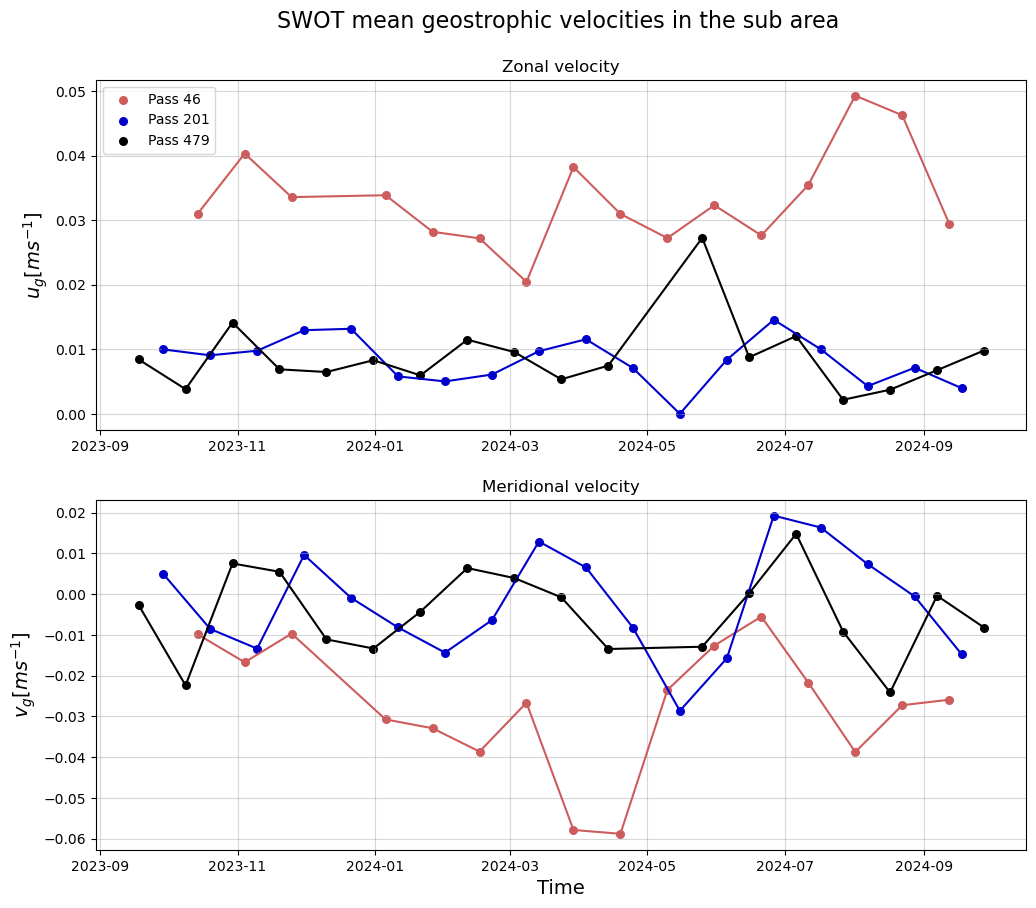

In [34]:
# ugos_filtered to a single mean value per file (i.e., per day)
mean_u_46 = combined46.ugos_filtered.where(combined46.quality_flag <= 20).mean(dim=['num_lines', 'num_pixels'], skipna=True)
mean_u_201 = combined201.ugos_filtered.where(combined201.quality_flag <= 20).mean(dim=['num_lines', 'num_pixels'], skipna=True)
mean_u_479 = combined479.ugos_filtered.where(combined479.quality_flag <= 20).mean(dim=['num_lines', 'num_pixels'], skipna=True)

# valid46 = combined46.ugos_filtered.notnull().any(dim=['num_lines', 'num_pixels'])
# combined46 = combined46.sel(file=valid46)
# valid201 = combined201.ugos_filtered.notnull().any(dim=['num_lines', 'num_pixels'])
# combined201 = combined201.sel(file=valid201)
# valid479 = combined479.ugos_filtered.notnull().any(dim=['num_lines', 'num_pixels'])
# combined479 = combined479.sel(file=valid479)

mean_v_46 = combined46.vgos_filtered.where(combined46.quality_flag <= 20).mean(dim=['num_lines', 'num_pixels'], skipna=True)
mean_v_201 = combined201.vgos_filtered.where(combined201.quality_flag <= 20).mean(dim=['num_lines', 'num_pixels'], skipna=True)
mean_v_479 = combined479.vgos_filtered.where(combined479.quality_flag <= 20).mean(dim=['num_lines', 'num_pixels'], skipna=True)


## Take first time per file
# time46 = combined46['time'].isel(num_lines=0, num_pixels=0)
# time201 = combined201['time'].isel(num_lines=0, num_pixels=0)
# time479 = combined479['time'].isel(num_lines=0, num_pixels=0)

time46 = combined46['time'].isel(num_lines=0)
time201 = combined201['time'].isel(num_lines=0)
time479 = combined479['time'].isel(num_lines=0)

# Step 3: Plot

fig, axs = plt.subplots(2, 1, figsize=(12, 10)) 

axs[0].scatter(time46, mean_u_46,s=30,color='indianred', label='Pass 46')
axs[0].plot(time46, mean_u_46,color='indianred')
axs[0].scatter(time201, mean_u_201, s=30,color='mediumblue', label='Pass 201')
axs[0].plot(time201, mean_u_201,color='mediumblue')
axs[0].scatter(time479, mean_u_479, s=30,color='k', label='Pass 479')
axs[0].plot(time479, mean_u_479,color='k')


axs[1].scatter(time46, mean_v_46,s=30,color='indianred', label='Pass 46')
axs[1].plot(time46, mean_v_46,color='indianred')
axs[1].scatter(time201, mean_v_201, s=30,color='mediumblue', label='Pass 201')
axs[1].plot(time201, mean_v_201,color='mediumblue')
axs[1].scatter(time479, mean_v_479, s=30,color='k', label='Pass 479')
axs[1].plot(time479, mean_v_479,color='k')


axs[0].set_title('Zonal velocity')
axs[0].set_ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)

axs[0].grid(True,alpha=0.5)
axs[1].set_title('Meridional velocity')
axs[1].set_ylabel(r'$v_{g} [m s^{-1}]$', fontsize=14)
axs[1].set_xlabel('Time', fontsize=14)
axs[1].grid(True,alpha=0.5)

plt.suptitle('SWOT mean geostrophic velocities in the sub area',x=0.51,y=0.95, fontsize=16,)
axs[0].legend(loc='upper left')

# plt.savefig('Time_series_SP.png', dpi=300);

In [ ]:
# time46 = combined46['time'].isel(num_lines=0,num_pixels=0)
# time46

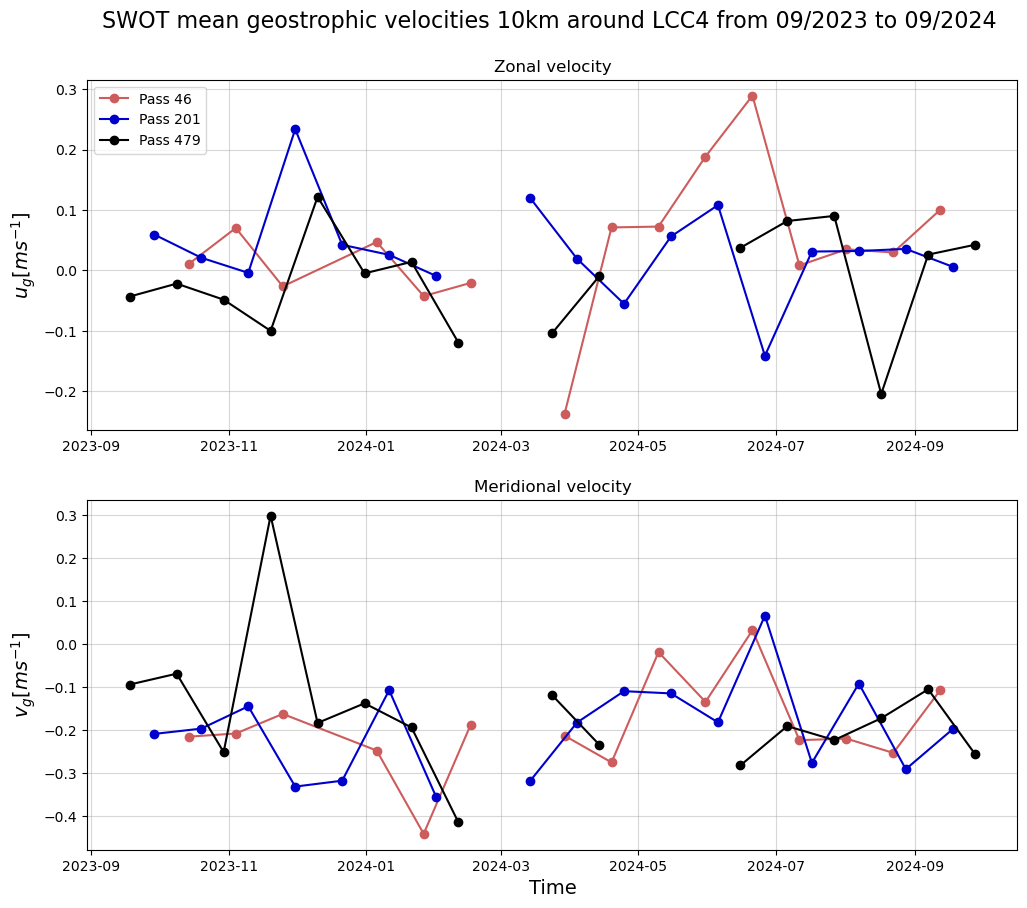

In [36]:
lon_LCC3 = -55.43833
lat_LCC3 = 53.40833

lon_LCC4 = -55.0333
lat_LCC4 =  53.53333

radius = 10 #km
dist46 = functions.haversine_distance(combined46.latitude, combined46.longitude, lat_LCC4, lon_LCC4)
dist201 = functions.haversine_distance(combined201.latitude, combined201.longitude, lat_LCC4, lon_LCC4)
dist479 = functions.haversine_distance(combined479.latitude, combined479.longitude, lat_LCC4, lon_LCC4)

mask46 = (dist46 < radius) & (combined46.quality_flag <= 20)
ugeosLCC3_46 = combined46['ugos_filtered'].where(mask46)
vgeosLCC3_46 = combined46['vgos_filtered'].where(mask46)

mask201 = (dist201 < radius) & (combined201.quality_flag <= 20)
ugeosLCC3_201 = combined201['ugos_filtered'].where(mask201)
vgeosLCC3_201 = combined201['vgos_filtered'].where(mask201)


mask479 = (dist479 < radius) & (combined479.quality_flag <= 20)
ugeosLCC3_479 = combined479['ugos_filtered'].where(mask479)
vgeosLCC3_479 = combined479['vgos_filtered'].where(mask479)


mean_u_46_zoom = ugeosLCC3_46.mean(dim=['num_lines', 'num_pixels'],skipna=True)
mean_u_201_zoom = ugeosLCC3_201.mean(dim=['num_lines', 'num_pixels'],skipna=True)
mean_u_479_zoom = ugeosLCC3_479.mean(dim=['num_lines', 'num_pixels'], skipna=True)

mean_v_46_zoom = vgeosLCC3_46.mean(dim=['num_lines', 'num_pixels'],skipna=True)
mean_v_201_zoom = vgeosLCC3_201.mean(dim=['num_lines', 'num_pixels'],skipna=True)
mean_v_479_zoom = vgeosLCC3_479.mean(dim=['num_lines', 'num_pixels'],skipna=True)


fig, axs = plt.subplots(2, 1, figsize=(12, 10)) 

axs[0].plot(time46, mean_u_46_zoom, marker='o',color='indianred', label='Pass 46')
axs[0].plot(time201, mean_u_201_zoom, marker='o',color='mediumblue', label = 'Pass 201')
axs[0].plot(time479, mean_u_479_zoom, marker='o', color='k', label='Pass 479')


axs[1].plot(time46, mean_v_46_zoom, marker='o',color='indianred', label='Pass 46')
axs[1].plot(time201, mean_v_201_zoom, marker='o', color='mediumblue', label='Pass 201')
axs[1].plot(time479, mean_v_479_zoom, marker='o',color='k',label='Pass 479')


axs[0].set_title('Zonal velocity')
axs[0].set_ylabel(r'$u_{g} [m s^{-1}]$', fontsize=14)

axs[0].grid(True,alpha=0.5)
axs[1].set_title('Meridional velocity')
axs[1].set_ylabel(r'$v_{g} [m s^{-1}]$', fontsize=14)
axs[1].set_xlabel('Time', fontsize=14)
axs[1].grid(True,alpha=0.5)

plt.suptitle('SWOT mean geostrophic velocities 10km around LCC4 from 09/2023 to 09/2024',x=0.51,y=0.95, fontsize=16,)
axs[0].legend(loc='upper left')

# plt.savefig('Time_series_SP4_year.png', dpi=300);

In [ ]:
# ds = xr.Dataset(
# data_vars = {
#             'mean_u46':(["time46"], mean_u_46_zoom.values),
#             'mean_v46':(["time46"], mean_v_46_zoom.values),
#     },
#   coords={
#         'time46': time46.values,
#     },
    
#     attrs={
#         'title': 'Mean SWOT velocities over pass 46',
    
#         'comment': 'For each cycle, only the first time is considered for shape homogenity'
#     }
# )    
# # ds.to_netcdf('SWOT_meanover46_LCC4.nc')

# ds = xr.Dataset(
# data_vars = {
#             'mean_u201':(["time201"], mean_u_201_zoom.values),
#             'mean_v201':(["time201"], mean_v_201_zoom.values)   
#     },
#   coords={
#         'time201': time201.values,
#     },
    
#     attrs={
#         'title': 'Mean SWOT velocities over pass 201',
    
#         'comment': 'For each cycle, only the first time is considered for shape homogenity'
#     }
# )    
# # ds.to_netcdf('SWOT_meanover201_LCC4.nc')

# ds = xr.Dataset(
# data_vars = {
#             'mean_u479':(["time479"], mean_u_479_zoom.values),
#             'mean_v479':(["time479"], mean_v_479_zoom.values)   
#     },
#   coords={
#         'time479': time479.values,
#     },
    
#     attrs={
#         'title': 'Mean SWOT velocities over pass 479',
    
#         'comment': 'For each cycle, only the first time is considered for shape homogenity'
#     }
# )    
# # ds.to_netcdf('SWOT_meanover479_LCC4.nc')

### Plot the different variables

In [ ]:
# %matplotlib qt

/var/folders/7d/76c27lb97m18k6jd1mcn12yc0000gn/T/ipykernel_55619/1316799295.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


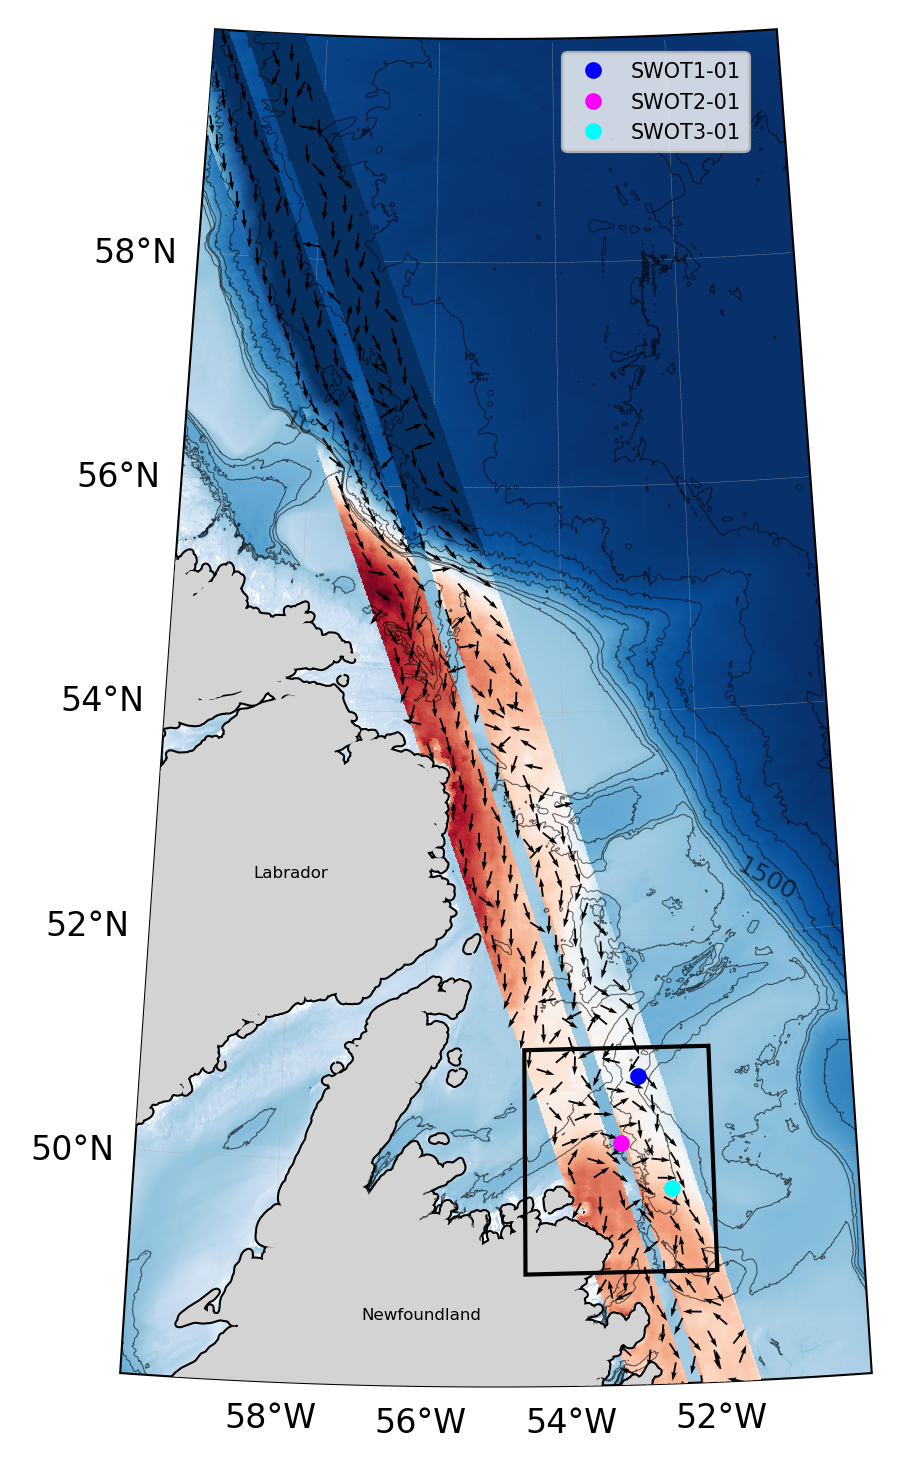

In [106]:
# fig, ax, rect = plots.figure(figsize=(5, 5),nrows=1,ncols=1,region=[-65, -45, 43, 63])
fig, ax, rect = plots.figure(figsize=(5, 5),nrows=1,ncols=1,region=[-60, -50, 48, 60])

cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.5, "pad": 0.015, "label": "SSH [m]","orientation":"vertical"})
# plot_kwargs = dict(x="longitude", y="latitude", cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=-0.45, vmax=0.1)
plot_kwargs = dict(x="longitude", y="latitude", cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=-0.4, vmax=0.1)
cb_args_off = dict(add_colorbar=False)

# mean_ssh46.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=2)
# mean_ssh201.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=2)
# mean_ssh479.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=2) 
ssh_mean.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=3) 

step = 10  #20 scale 35 and width 0.003  
ax.quiver(lon20[::step, ::step].values,lat20[::step, ::step].values,mean_u20[::step, ::step].values,mean_v20[::step, ::step].values,transform=ccrs.PlateCarree(),
    scale=40, color='k',zorder=3)

# ax.quiver(lon46[::step, ::step].values,lat46[::step, ::step].values,mean_u46[::step, ::step].values,mean_v46[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=40, color='snow',headwidth=3, zorder=3)

# ax.quiver(lon201[::step, ::step].values,lat201[::step, ::step].values,mean_u201[::step, ::step].values,mean_v201[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=40, color='snow',headwidth=3,zorder=3)

# ax.quiver(lon479[::step, ::step].values,lat479[::step, ::step].values,mean_u479[::step, ::step].values,mean_v479[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=40, color='snow',headwidth=3,zorder=3)


# lcc1 = ax.plot(-55.56367, 53.37517, '*', c='fuchsia', label='LCC1', markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of LCC1 mooring
# lcc2 = ax.plot(-55.43833, 53.40833, '*', c='fuchsia', label='LCC2',markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of LCC2 mooring
# lcc3 = ax.plot(-55.16233, 53.491, '*', c='k', label='LCC3', markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of LCC1 mooring
# lcc4 = ax.plot(-55.03333, 53.53333, '*', c='fuchsia', label='LCC4',markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of LCC2 mooring

# x=[-55.03333, -55.16233, -55.43833, -55.56367]
# y=[53.53333,  53.491, 53.40833, 53.37517]
# lcc = ax.plot(x,y, 'g', label='LCC moorings', transform=ccrs.PlateCarree(), zorder=4)[0]

mo1 = ax.plot(-53.00083, 50.74967, 'o', c='b', label='SWOT1-01', markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of mooring 1
mo2 = ax.plot(-53.26417, 50.16467, 'o', c='fuchsia', label='SWOT2-01', markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of mooring 2
mo3 = ax.plot(-52.58427, 49.74992, 'o', c='cyan', label='SWOT3-01', markersize=3, transform=ccrs.PlateCarree(), zorder=4)[0]  # position of mooring 3

# ax.legend(handles=[lcc], fontsize=5, loc = 'upper right', bbox_to_anchor=(0.85, 0.99))
ax.legend(handles=[mo1, mo2,mo3], fontsize=5, loc = 'upper right', bbox_to_anchor=(0.85, 0.99))

plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

norm = mcolors.PowerNorm(gamma=0.35, vmin=10, vmax=3500)
BP = (-1*bathy.elevation).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap='Blues', add_colorbar=False)

BC = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.6, levels=np.arange(1000, 4500, 500), 
                                       linewidths=0.25, zorder=3)

BC2 = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.6, levels=np.arange(300, 600, 100), 
                                       linewidths=0.25, zorder=3)
#(200, 800, 200)
ax.clabel(BC, inline=True, fontsize=6, zorder=2)
# ax.clabel(BC2, inline=True, fontsize=6, zorder=2)

ax.text(-58, 52.5, "Labrador",
        transform=ccrs.PlateCarree(),
        horizontalalignment='center',
        fontsize=4)
ax.text(-56, 48.6, "Newfoundland",transform=ccrs.PlateCarree(), horizontalalignment='center', fontsize=4)

# lon_range = -56, -53
# lat_range = 50.4, 55.4
# square = patches.Rectangle((lon_range[0], lat_range[0]), lon_range[1]-lon_range[0], lat_range[1]-lat_range[0], edgecolor='k', linewidth=0.5,facecolor='none', zorder=3,transform=ccrs.PlateCarree())
# ax.add_patch(square)
# lon = ds46.longitude.isel(num_lines = line_idx)
# lat = ds46.latitude.isel(num_lines = line_idx)
# scatter = ax.plot(lon, lat, 
#                     color='k', alpha=0.8, zorder=4,label='cross-track line', linewidth=0.5,transform=ccrs.PlateCarree())

# ax.plot([-55.6508, -53.8696], [53.3127, 53.8646],  
#         color='r', 
#         linewidth=1, 
#         transform=ccrs.PlateCarree(),
#         zorder=4)  # zorder=4 to match other elements

# ax.plot([-53.8696, -50.2795], [53.8646, 46.7089],
#         color='r', 
#         linewidth=1, 
#         transform=ccrs.PlateCarree(),
#         zorder=4)  # zorder=4 to match other elements

# ax.plot([-50.2795, -51.8235], [46.7089, 45.8096],
#         color='r', 
#         linewidth=1, 
#         transform=ccrs.PlateCarree(),
#         zorder=4)  # zorder=4 to match other elements

# ax.plot([-51.8235, -53.1607], [45.8096,46.5873],
#         color='r', 
#         linewidth=1, 
#         transform=ccrs.PlateCarree(),
#         zorder=4)  # zorder=4 to match other elements

lon_range = -54.6, -52
lat_range = 49, 51
square = patches.Rectangle((lon_range[0], lat_range[0]), lon_range[1]-lon_range[0], lat_range[1]-lat_range[0], edgecolor='k', facecolor='none', transform=ccrs.PlateCarree(),zorder=4)
ax.add_patch(square)
plt.tight_layout()
plt.show() 
fig.savefig("Figures/ssh_FS_phase.png", dpi=300)  

In [ ]:
stop

In [ ]:
# getting the velocities above the target line
target_lat = [53.3127, 53.8646]
target_lon = [-55.6508, -53.8696]

ds = xr.open_dataset(Science_pass46[4])
ssh46 = ds46.ssha_filtered
num_lines = ssh46.sizes['num_lines']

line_distances = np.zeros(num_lines)

for i in range(num_lines):
    line_lats = ds46.latitude.isel(num_lines=i).values
    line_lons = ds46.longitude.isel(num_lines=i).values
    min_dist = float('inf')
    for tlat, tlon in zip(line_lats, line_lons):
            dist = functions.haversine_distance(tlat, tlon, target_lat[0], target_lon[0])
            min_dist = min(min_dist, dist)
    
    line_distances[i] = min_dist
    
line_idx = int(np.argmin(line_distances))
print(f"Closest cross_track line index: {line_idx}, distance = {line_distances[line_idx]:.2f} km")

In [ ]:
# Define maximum distance threshold (in km) for points to be considered "on the line"
threshold_distance = 0.5  # Adjust as needed

# Create empty list to store data points along the line
line_data_points = []

# Iterate through all data points and check if they're close to the line
for i in range(ssh46.sizes['num_lines']):
    for j in range(ssh46.sizes['num_pixels']):
        lat = ds46.latitude.isel(num_lines=i, num_pixels=j).item()
        lon = ds46.longitude.isel(num_lines=i, num_pixels=j).item()
        
        # Calculate distance from this point to our target line
        dist = functions.point_to_line_distance(lat, lon, target_lat[0], target_lon[0], target_lat[1], target_lon[1])
        
        # If point is close enough to the line, add it to our collection
        if dist <= threshold_distance:
            data_point = {
                'latitude': lat,
                'longitude': lon,
                'ssha': ssh46.isel(num_lines=i, num_pixels=j).item(),
                'distance_to_line': dist,
                'line_idx': i,
                'pixel_idx': j
            }
            line_data_points.append(data_point)

print(f"Found {len(line_data_points)} data points along the target line")

In [ ]:
# Method 1: Using the indices directly from your collected data points
lon = [ds46.longitude.isel(num_lines=point['line_idx'], num_pixels=point['pixel_idx']).item() 
                 for point in line_data_points]

lat = [ds46.latitude.isel(num_lines=point['line_idx'], num_pixels=point['pixel_idx']).item() 
                 for point in line_data_points]

ugeos = [ds46.ugos_filtered.isel(num_lines=point['line_idx'], num_pixels=point['pixel_idx']).item() 
                 for point in line_data_points]

vgeos = [ds46.vgos_filtered.isel(num_lines=point['line_idx'], num_pixels=point['pixel_idx']).item() 
                 for point in line_data_points]

# Method 2: If you already have the indices and want to extract them in bulk
# line_indices = [point['line_idx'] for point in line_data_points]
# pixel_indices = [point['pixel_idx'] for point in line_data_points]
# all_longitudes = ds46.longitude.isel(num_lines=line_indices, num_pixels=pixel_indices).values

# # Method 3: You can also just access the longitudes you already stored
# all_longitudes = [point['longitude'] for point in line_data_points]

In [ ]:
# fig, ax, rect = plots.figure(figsize=(4, 4),nrows=1,ncols=1,region=[-70, -45, 42, 70])
fig, ax, rect = plots.figure(figsize=(4, 4),nrows=1,ncols=1,region=[-60, -50, 48, 56])
cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.3, "pad": 0.02, "label": "u [m/s]"})
plot_kwargs = dict(x="longitude", y="latitude", cmap="bwr", transform=ccrs.PlateCarree())
ds46.ugos_filtered.plot.pcolormesh(ax=ax, vmin=-0.4,vmax=0.4,**plot_kwargs, **cb_args) 

scatter = ax.plot(lon, lat, color='k', alpha=0.8, zorder=3,label='cross-track line', linewidth=0.5,transform=ccrs.PlateCarree())
step = 1
lon = np.array(lon)
lat = np.array(lat)
ugeos = np.array(ugeos)
vgeos = np.array(vgeos)
ax.quiver(lon,lat,ugeos,vgeos,transform=ccrs.PlateCarree(),
    scale=30, color='k',zorder=4)

# mo2 = ax.plot(-53.26417, 50.16467, 'o', c='fuchsia', label='SWOT2-01', markersize=0.5, transform=ccrs.PlateCarree())[0]  # position of mooring 2
plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

ax.legend(fontsize=4, loc = 'upper right', bbox_to_anchor=(0.96, 0.98))
ax.tick_params(right=False, labelright=False)
# ax.text(-58, 52.5, "Labrador",
#         transform=ccrs.PlateCarree(),
#         horizontalalignment='center',
#         fontsize=4)
plt.show() 
# fig.savefig("map_ugeos12may_line.png", dpi=300)  

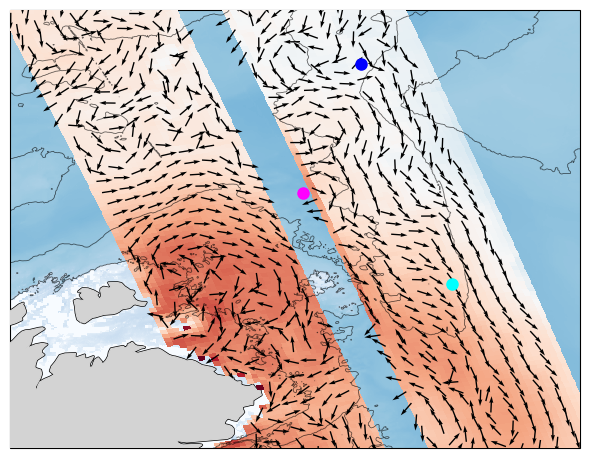

In [118]:
import cartopy.feature as cfeat
fig, ax = plt.subplots(figsize=(6, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([-56, -53, 50.4, 55.4], crs=ccrs.PlateCarree())
ax.set_extent([-54.6, -52, 49, 51], crs=ccrs.PlateCarree())
ax.coastlines(zorder=3, linewidth=2)
ax.add_feature(cfeat.LAND, color='lightgray', zorder=3)

# cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.5, "pad": 0.001, "label": "SSH [m]","orientation":"vertical"})
plot_kwargs = dict(x="longitude", y="latitude", cmap="RdBu_r", vmin=-0.4, vmax=0.1)
# ssh_mean.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)

# cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.5, "pad": 0.015, "label": "SSH [m]","orientation":"vertical"})
# plot_kwargs = dict(x="longitude", y="latitude", cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=-0.45, vmax=0.15)
cb_args_off = dict(add_colorbar=False)

# mean_ssh46.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=3)
# mean_ssh201.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=3)
# mean_ssh479.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=3) 
ssh_mean.plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args_off, zorder=3) 

step = 5  #20 scale 35 and width 0.003

# ax.quiver(lon46[::step, ::step].values,lat46[::step, ::step].values,mean_u46[::step, ::step].values,mean_v46[::step, ::step].values, transform=ccrs.PlateCarree(),
#     scale=30, color='k',headwidth=4, zorder=4)

# ax.quiver(lon201[::step, ::step].values,lat201[::step, ::step].values,mean_u201[::step, ::step].values,mean_v201[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=30, color='k',headwidth=4,zorder=4)

# ax.quiver(lon479[::step, ::step].values,lat479[::step, ::step].values,mean_u479[::step, ::step].values,mean_v479[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=30, color='k',headwidth=4,zorder=4)

step = 3  #20 scale 35 and width 0.003
ax.quiver(lon20[::step, ::step].values,lat20[::step, ::step].values,mean_u20[::step, ::step].values,mean_v20[::step, ::step].values,transform=ccrs.PlateCarree(),
    scale=35, color='k',zorder=3)


mo1 = ax.plot(-53.00083, 50.74967, 'o', c='b', label='SWOT1-01', markersize=8, zorder=4)[0]  # position of mooring 1
mo2 = ax.plot(-53.26417, 50.16467, 'o', c='fuchsia', label='SWOT2-01', markersize=8, zorder=4)[0]  # position of mooring 2
mo3 = ax.plot(-52.58427, 49.74992, 'o', c='cyan', label='SWOT3-01', markersize=8, zorder=4)[0]  # position of mooring 3


# x=[-55.03333, -55.16233, -55.43833, -55.56367]
# y=[53.53333,  53.491, 53.40833, 53.37517]
# # # lcc = ax.plot(x,y, 'g', label='LCC moorings', transform=ccrs.PlateCarree(), zorder=4)[0]
# for i in range(len(x)):
#     lcc = ax.scatter(x[i],y[i], marker='o',c='g', label='LCC moorings', s=20,transform=ccrs.PlateCarree(), zorder=4)

# BP = (-1*bathy.elevation).plot.pcolormesh(ax=ax, vmin=50, vmax=400, cmap='Blues', add_colorbar=False)
BC = (-1*bathy.elevation).plot.contour(ax=ax, colors='k', alpha=0.6, levels=np.arange(100, 650, 150), linewidths=0.6,zorder=3)

norm = mcolors.PowerNorm(gamma=0.35, vmin=10, vmax=3500)
BP = (-1*bathy.elevation).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), norm=norm, cmap='Blues', add_colorbar=False)
ax.clabel(BC, inline=True, fontsize=6, zorder=2)

plt.tight_layout()
fig.savefig("Figures/ssh_FS_zoom_plat.png", dpi=300)  
plt.show()

##                                                     Maps during november and december

In [ ]:
swot6 = xr.open_dataset('pass_science_phase_46/subset_SWOT_L3_LR_SSH_Expert_006_046_20231104T035418_20231104T044545_v2.0.1.nc')
swot6 = swot6.where(swot6.quality_flag == 0)
swot7 = xr.open_dataset('pass_science_phase_46/subset_SWOT_L3_LR_SSH_Expert_007_046_20231125T003923_20231125T013050_v2.0.1.nc')
swot7 = swot7.where(swot7.quality_flag == 0)

In [ ]:
swot6pass201 = xr.open_dataset('pass_science_phase_201/subset_SWOT_L3_LR_SSH_Expert_006_201_20231109T164835_20231109T174001_v2.0.1.nc')
swot6pass201 = swot6pass201.where(swot6pass201.quality_flag == 0)
swot7pass201 = xr.open_dataset('pass_science_phase_201/subset_SWOT_L3_LR_SSH_Expert_007_201_20231130T133341_20231130T142507_v2.0.1.nc')
swot7pass201 = swot7pass201.where(swot7pass201.quality_flag == 0)

In [ ]:
swot6pass479 = xr.open_dataset('pass_science_phase_479/subset_SWOT_L3_LR_SSH_Expert_006_479_20231119T151052_20231119T160218_v2.0.1.nc')
swot6pass479 = swot6pass479.where(swot6pass479.quality_flag == 0)
swot7pass479 = xr.open_dataset('pass_science_phase_479/subset_SWOT_L3_LR_SSH_Expert_007_479_20231210T115557_20231210T124723_v2.0.1.nc')
swot7pass479 = swot7pass479.where(swot7pass479.quality_flag == 0)

In [ ]:
plt.figure(figsize = (10,4), dpi = 180)

plt.subplot(151)
plt.pcolormesh(swot6.longitude, swot6.latitude, swot6.ssha_filtered+swot6.mdt, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'SSH [m]')
plt.clim(-0.25,0.25)

plt.subplot(152)
plt.pcolormesh(swot7.longitude, swot7.latitude, swot7.ssha_filtered+swot7.mdt, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'SSH [m]')
plt.clim(-0.25,0.25)

plt.subplot(153)
plt.pcolormesh(swot6pass201.longitude, swot6pass201.latitude, swot6pass201.ssha_filtered+swot6pass201.mdt, cmap = 'RdBu_r')
plt.colorbar(orientation = 'horizontal', label = r'SSH [m]')
plt.clim(-0.25,0.25)

# plt.subplot(154)
# plt.pcolormesh(swot.longitude, swot.latitude, swot.sr_csiro, cmap = 'YlGnBu_r')
# plt.colorbar(orientation = 'horizontal', label = 'SR')
# # plt.clim(0,0.5)

# plt.subplot(155)
# plt.pcolormesh(swot.longitude, swot.latitude, swot.OW_csiro, cmap = 'RdBu_r')
# plt.colorbar(orientation = 'horizontal', label = 'OW/f**2')
# plt.clim(-0.25,0.25)

plt.tight_layout()

In [ ]:
# fig, ax, rect = plots.figure(figsize=(3, 3),nrows=1,ncols=1,region=[-57, -52, 51, 55])

# cb_args = dict(add_colorbar=True, cbar_kwargs={"shrink": 0.5, "pad": 0.015, "label": "SSH [m]","orientation":"vertical"})
# plot_kwargs = dict(x="longitude", y="latitude", cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=-0.15, vmax=0.15)

# (swot6.ssha_filtered+swot6.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)
# (swot7.ssha_filtered+swot7.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)
# (swot6pass201.ssha_filtered+swot6pass201.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)
# (swot7pass201.ssha_filtered+swot7pass201.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)
# (swot6pass479.ssha_filtered+swot6pass479.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)
# (swot5pass479.ssha_filtered+swot5pass479.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, **cb_args, zorder=3)

# step = 5 

# ax.quiver(swot6.longitude[::step, ::step].values,swot6.latitude[::step, ::step].values, swot6.ugos_filtered[::step, ::step].values, swot6.vgos_filtered[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=15, color='k',headwidth=3, zorder=4)

# ax.quiver(swot7.longitude[::step, ::step].values,swot7.latitude[::step, ::step].values, swot7.ugos_filtered[::step, ::step].values, swot7.vgos_filtered[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=15, color='k',headwidth=3, zorder=4)

# ax.quiver(swot6pass201.longitude[::step, ::step].values,swot6pass201.latitude[::step, ::step].values, swot6pass201.ugos_filtered[::step, ::step].values, swot6pass201.vgos_filtered[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=15, color='k',headwidth=3, zorder=4)

# ax.quiver(swot7pass201.longitude[::step, ::step].values,swot7pass201.latitude[::step, ::step].values, swot7pass201.ugos_filtered[::step, ::step].values, swot7pass201.vgos_filtered[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=15, color='k',headwidth=3, zorder=4)

# ax.quiver(swot6pass479.longitude[::step, ::step].values,swot6pass479.latitude[::step, ::step].values, swot6pass479.ugos_filtered[::step, ::step].values, swot6pass479.vgos_filtered[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=15, color='k',headwidth=3, zorder=4)

# ax.quiver(swot6pass479.longitude[::step, ::step].values,swot6pass479.latitude[::step, ::step].values, swot6pass479.ugos_filtered[::step, ::step].values, swot6pass479.vgos_filtered[::step, ::step].values,transform=ccrs.PlateCarree(),
#     scale=15, color='k',headwidth=3, zorder=4)

# x=[-55.03333, -55.16233, -55.43833, -55.56367]
# y=[53.53333,  53.491, 53.40833, 53.37517]
# for i in range(len(x)):
#     lcc = ax[0].scatter(x[i],y[i], marker='o',c='g', label='LCC moorings', s=2,transform=ccrs.PlateCarree(), zorder=4)

# plots.axis_shape(ax[0], rect, addCoastline=True, addCheckerboard=False)


# BC = (-1*bathy.elevation).plot.contour(ax=ax[0], transform=ccrs.PlateCarree(), colors='k', alpha=0.6, levels=np.arange(400, 600, 100), linewidths=0.5,zorder=3)
# # ax.clabel(BC, BC.levels, inline=True, fontsize=6, zorder=1)

# # ax.text(-54.5, 48.6, "Newfoundland",transform=ccrs.PlateCarree(), horizontalalignment='center', fontsize=6)

# plt.show() 
# # fig.savefig("ssh_SP_zoom.png", dpi=300)  

In [ ]:
fig, axes, rects = plots.figure(figsize=(10, 9), nrows=3, ncols=2, region=[-57, -52, 51, 55])

# cb_args = dict(add_colorbar=False)  # Suppress auto colorbars 
plot_kwargs = dict(x="longitude", y="latitude", cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=-0.15, vmax=0.15)
step = 4

datasets = [swot6, swot7, swot6pass201, swot7pass201, swot6pass479, swot7pass479]

for i, (ds, ax) in enumerate(zip(datasets, axes.flat)):
    # SSH + MDT
    (ds.ssha_filtered + ds.mdt).plot.pcolormesh(ax=ax, **plot_kwargs, zorder=3)
    
    ax.quiver(
        ds.longitude[::step, ::step].values,
        ds.latitude[::step, ::step].values,
        ds.ugos_filtered[::step, ::step].values,
        ds.vgos_filtered[::step, ::step].values,
        transform=ccrs.PlateCarree(), scale=7, color='k', headwidth=3, zorder=4
    )
    
    x = [-55.03333, -55.16233, -55.43833, -55.56367]
    y = [53.53333,  53.491, 53.40833, 53.37517]
    ax.scatter(x, y, marker='o', c='g', label='LCC moorings', s=2, transform=ccrs.PlateCarree(), zorder=3)

    BC = (-1 * bathy.elevation).plot.contour(
        ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=0.6,
        levels=np.arange(400, 600, 100), linewidths=0.5, zorder=3
    )
    ax.set_extent([-57, -52, 51, 55], crs=ccrs.PlateCarree())
    plots.axis_shape(ax, rects, addCoastline=True, addCheckerboard=False)

# colorbar manually to the right
# cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
# sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=-0.15, vmax=0.15))
# fig.colorbar(sm, cax=cbar_ax, label="SSH [m]", orientation='vertical')

# plt.show()
# fig.savefig("MAPS_SP_zoom_flagged.png", dpi=400)